In [1]:
from google.colab import drive
import os

drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/ML-Climate-Predicting-Wildfires/src')

Mounted at /content/drive


## WHP dataset 

Dillon, Gregory K; Gilbertson-Day, Julie W. 2020. Wildfire Hazard Potential for the United States (270-m), version 2020. 3rd Edition. Fort Collins, CO: Forest Service Research Data Archive. https://doi.org/10.2737/RDS-2015-0047-3

The data presented here are the product of modeling, and as such carry an inherent degree of error and uncertainty. Users are strongly encouraged to read and fully comprehend the metadata and other available documentation prior to data use. No warranty is made by the Originator as to the accuracy, reliability, or completeness of these data for individual use or aggregate use with other data, or for purposes not intended by the Originator. These datasets are intended to provide nationally-consistent information for the purpose of comparing relative wildfire risk among communities nationally or within a state or county. Data included here are not intended to replace locally-calibrated state, regional, or local risk assessments where they exist. It is the responsibility of the user to be familiar with the value, assumptions, and limitations of these national data publications. Managers and planners must evaluate these data according to the scale and requirements specific to their needs. Spatial information may not meet National Map Accuracy Standards. This information may be updated without notification.

In [22]:
# !pip install rasterio
# !pip install fiona
# !pip install geopandas
# !pip install contextily
!pip install rioxarray

     |████████████████████████████████| 47 kB 2.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for rioxarray: filename=rioxarray-0.9.1-py3-none-any.whl size=54611 sha256=8378f049b1e59a83037b5ec5894d646b30f4df30d133bf730d37afb9a18bfb8b
  Stored in directory: /root/.cache/pip/wheels/07/da/9e/1cc57b2e7a29a206893db83e984a341e2e94378263e0798229
Successfully built rioxarray


In [13]:
import rasterio

raster_summer2021_path = "data/RawData/2021_Wind-enhanced_Fire_Potential_Index_Forecast_1_DATA/emodis-wfpi-forecast-1_data_20210710_20210710/emodis-wfpi_data_20210710_20210710.tiff"
raster_summer2021 = rasterio.open(raster_summer2021_path)

In [14]:
import numpy as np

raster_summer2021_arr = raster_summer2021.read()
raster_summer2021_arr_valid = raster_summer2021_arr[raster_summer2021_arr<200]
np.mean(raster_summer2021_arr_valid), np.std(raster_summer2021_arr_valid)

(41.82572444794226, 33.185456555666214)

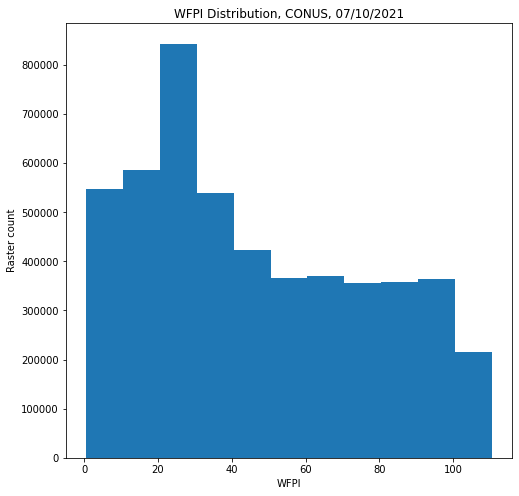

In [15]:
from matplotlib import pyplot as plt

plt.figure(figsize=(8, 8))
plt.hist(raster_summer2021_arr_valid, bins=[x+0.5 for x in range(0,120,10)])
plt.title("WFPI Distribution, CONUS, 07/10/2021")
plt.xlabel('WFPI')
plt.ylabel('Raster count');

In [16]:
import fiona 
import geopandas as gpd
import pandas as pd
import contextily as cx
import datetime

path_to_data = "data/RawData/NIFC_Wildland_Fire_Perimeters.gdb"
fires_gdf = gpd.read_file(path_to_data)
fires_gdf

,ABCDMisc,ADSPermissionState,CalculatedAcres,ContainmentDateTime,ControlDateTime,DailyAcres,DiscoveryAcres,DispatchCenterID,EstimatedCostToDate,FinalFireReportApprovedByTitle,...,OrganizationalAssessment,StrategicDecisionPublishDate,CreatedOnDateTime_dt,ModifiedOnDateTime_dt,Source,GlobalID,IsCpxChild,CpxName,CpxID,geometry
0,None,CERTIFIED,50.64,2020-08-06T23:13:07+00:00,2020-08-06T23:13:24+00:00,50.6,20.0,MTMCC,NaN,None,...,None,None,2020-08-06T19:50:29+00:00,2020-08-12T20:46:01+00:00,IRWIN,{E5436898-ED0D-4CB1-90C0-D61915FE1F29},NaN,None,None,POINT (-104.45751 45.78504)
1,None,DEFAULT,NaN,None,None,NaN,0.1,CALACC,NaN,None,...,None,None,2020-02-28T20:52:36+00:00,2020-02-28T20:52:36+00:00,IRWIN,{0E79B7FD-2882-43CF-8CFA-911BD1C8F77A},NaN,None,None,POINT (-118.18071 33.80898)
2,None,DEFAULT,NaN,2017-10-18T00:30:00+00:00,2017-10-18T00:35:00+00:00,50.0,50.0,MTKIC,NaN,None,...,None,None,2017-10-18T13:46:40+00:00,2017-11-09T22:08:19+00:00,IRWIN,{FAC59A92-E6AD-443B-8625-4AAABCF7F533},NaN,None,None,POINT (-114.83541 48.07395)
3,None,DEFAULT,NaN,None,None,NaN,NaN,CAMVIC,NaN,None,...,None,None,2019-07-01T20:10:12+00:00,2019-07-01T20:10:12+00:00,IRWIN,{5DF06F41-9948-49D3-B00A-2D3A1D1049C5},NaN,None,None,POINT (-117.15390 33.17639)
4,None,DEFAULT,NaN,None,None,NaN,NaN,None,NaN,None,...,None,None,2016-06-20T22:39:02+00:00,2016-06-20T22:39:02+00:00,IRWIN,{F378818E-D541-4E0A-9A44-C81886C2B8B4},NaN,None,None,POINT (-121.10418 38.83473)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212233,None,DEFAULT,NaN,None,None,NaN,NaN,SDGPC,NaN,None,...,None,None,2022-03-21T13:24:39+00:00,2022-03-21T13:24:39+00:00,IRWIN,{C15A3B09-A767-40FB-8404-DFA2CBC0F42F},0.0,None,None,POINT (-99.45001 44.06140)
212234,None,DEFAULT,NaN,None,None,1.0,1.0,ILILC,NaN,None,...,None,None,2022-03-21T13:29:12+00:00,2022-03-21T13:46:28+00:00,IRWIN,{054AFEB9-7BAF-425E-B528-2E6C436547D0},0.0,None,None,POINT (-88.03056 41.37154)
212235,None,DEFAULT,NaN,None,None,1.0,1.0,ILILC,NaN,None,...,None,None,2022-03-21T13:36:34+00:00,2022-03-21T13:48:06+00:00,IRWIN,{9F4846CC-07EC-4D84-9D37-DD016F11A502},0.0,None,None,POINT (-88.15883 41.34809)
212236,None,DEFAULT,NaN,None,None,1.0,1.0,ILILC,NaN,None,...,None,None,2022-03-21T13:39:35+00:00,2022-03-21T13:48:28+00:00,IRWIN,{A2794C09-838A-4434-97F4-9E82289DDC18},0.0,None,None,POINT (-88.16037 41.35492)


In [18]:
fires_gdf = fires_gdf[(fires_gdf['POOState']!='US-AK')&(fires_gdf['POOState']!='US-HI')]
fires_gdf['discovery_date'] = pd.to_datetime(fires_gdf['FireDiscoveryDateTime']).dt.tz_localize(None)
fires_gdf = fires_gdf[fires_gdf['discovery_date'] > datetime.datetime(year=2017,month=1,day=1)]

In [19]:
fires_rasterproj = fires_gdf.to_crs('PROJCS["Sphere_ARC_INFO_Lambert_Azimuthal_Equal_Area",GEOGCS["GCS_Sphere_ARC_INFO",DATUM["D_Sphere_ARC_INFO",SPHEROID["Sphere_ARC_INFO",6370997,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",45],PARAMETER["longitude_of_center",-100],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]')

In [20]:
summer_2021_fires = fires_rasterproj[(fires_rasterproj['discovery_date'] > datetime.datetime(year=2021,month=7,day=1)) & (fires_rasterproj['discovery_date'] > datetime.datetime(year=2021,month=7,day=31))]

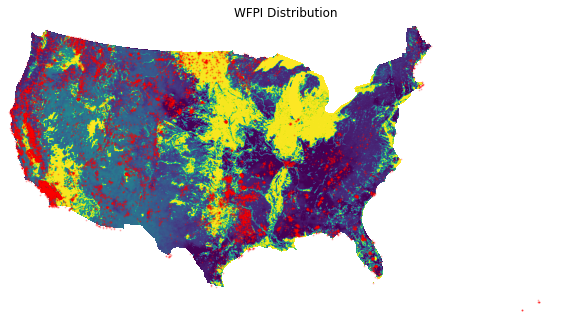

In [23]:
from rasterio.plot import plotting_extent, show
import rioxarray as rxr

fig, ax = plt.subplots(figsize=(10, 10))
rasterio_summer2021 = rxr.open_rasterio(raster_summer2021_path, masked=True).squeeze()

show(raster_summer2021, 
     title="WHP, CONUS, 07/10/2021 vs. Summer 2021 Wildfire Occurences", ax=ax)
plt.title("WFPI Distribution")
summer_2021_fires.plot(ax=ax,
              marker='o',
              markersize=1,
              alpha=0.2,
              color='red')
ax.set_axis_off()
plt.show()

In [26]:
positive_sample_ids = np.unique([f[:-6] for f in os.listdir('data/TrainingData/Class-Data/1') if '.npy' in f])
positive_sample_ids

array(['2017-AKGAD-000162', '2017-AKGAD-000279', '2017-AKGAD-000280', ...,
       '2021-TXTXS-210859', '2021-UTUWF-000008', '2021-WYCRX-210140'],
      dtype='<U21')

In [28]:
positive_samples_rasterproj = fires_rasterproj[fires_rasterproj['UniqueFireIdentifier'].isin(positive_sample_ids)]
post_2017_fire_count = len(positive_samples_rasterproj)
post_2017_fire_count

2703

In [30]:
fire_hazards = {}
missing_data_count = 0
for i_year in range(2017, 2023):
    fires_year_rasterproj = positive_samples_rasterproj[(positive_samples_rasterproj['discovery_date'] > datetime.datetime(year=i_year,month=1,day=1)) & (positive_samples_rasterproj['discovery_date'] < datetime.datetime(year=i_year+1,month=1,day=1))]
    fire_coord_list = [(fire_id, date, (x,y)) for fire_id, date, x, y in zip(fires_year_rasterproj['UniqueFireIdentifier'], fires_year_rasterproj['discovery_date'], \
                                                                             fires_year_rasterproj['geometry'].x, fires_year_rasterproj['geometry'].y)]
    date_coord_map = {discovery_date.date():{'ids':[], 'coords':[]} for _, discovery_date, _ in fire_coord_list}
    for fire_id, discovery_date, coord in fire_coord_list:
        date_coord_map[discovery_date.date()]['ids'].append(fire_id)
        date_coord_map[discovery_date.date()]['coords'].append(coord)
    for date in date_coord_map:
        id_list_date = date_coord_map[date]['ids']
        coord_list_date = date_coord_map[date]['coords']
        date_str = date.strftime("%Y%m%d") 
        if i_year == 2018 or i_year == 2022 or (i_year == 2021 and date.month >=6): 
            folder_name = "emodis-wfpi-forecast-1_data_{}_{}".format(date_str,date_str)
            data_name = "emodis-wfpi_data_{}_{}".format(date_str,date_str)
            raster_path_date = "data/RawData/{}_Wind-enhanced_Fire_Potential_Index_Forecast_1_DATA/{}/{}.tiff".format(i_year, folder_name, data_name)
        else:
            folder_name = "emodis_wfpi_data_{}_{}".format(date_str,date_str)
            data_name = "emodis_wfpi_data_{}_{}".format(date_str,date_str)
            raster_path_date = "data/RawData/{}_Wind-enhanced_Fire_Potential_Index_Forecast_1_DATA/{}.tiff".format(i_year, folder_name, data_name)
        try:
            raster_date = rasterio.open(raster_path_date)
            fire_hazards_date = [x[0] for x in raster_date.sample(coord_list_date)]
            for fire_id, fire_hazard in zip(id_list_date, fire_hazards_date):
                fire_hazards[fire_id] = fire_hazard
        except Exception as e:
            print(e)
            missing_data_count += len(coord_list_date)
print('WFPI identified for {}/{} fires'.format(post_2017_fire_count-missing_data_count, post_2017_fire_count))

data/RawData/2020_Wind-enhanced_Fire_Potential_Index_Forecast_1_DATA/emodis_wfpi_data_20200229_20200229.tiff: No such file or directory
WFPI identified for 2687/2703 fires


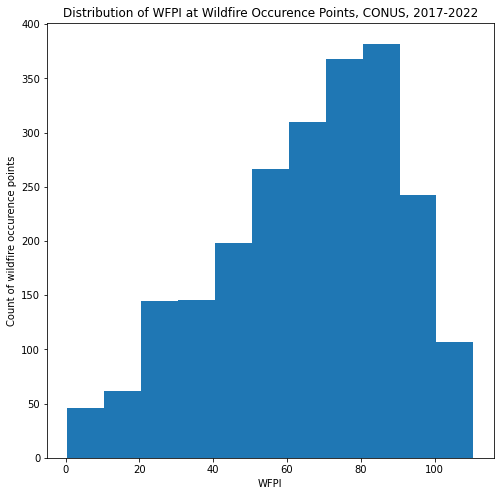

In [31]:
plt.figure(figsize=(8, 8))
plt.hist(fire_hazards.values(), bins=[x+0.5 for x in range(0,120,10)])
plt.title("Distribution of WFPI at Wildfire Occurence Points, CONUS, 2017-2022")
plt.xlabel('WFPI')
plt.ylabel('Count of wildfire occurence points');

In [34]:
import json 

fire_image_dir = "data/TrainingData/Class-Data/0/"
download_log_file = "{}download_log.json".format(fire_image_dir)

if os.path.exists(download_log_file):
  with open(download_log_file) as f:
    selected_image_info = json.load(f)

In [52]:
from shapely.geometry import Point

points = []
fire_dates = []
for fire_id, info in selected_image_info.items():
  try:
    x,y = info[0]
    fire_date = fires_gdf['discovery_date'][fires_gdf['UniqueFireIdentifier']==fire_id].values[0]
    point = Point(x,y)
    points.append(point)
    fire_dates.append(fire_date)
  except Exception as e:
    pass

In [58]:
neg_samples = gpd.GeoDataFrame(points, crs='EPSG:4326', columns=['geometry'])
neg_samples = neg_samples.to_crs(fires_rasterproj.crs)
neg_samples['date'] = fire_dates

In [94]:
negatve_sample_hazards = []
missing_data_count = 0
for i_year in range(2017, 2023):
    samples_year_rasterproj = neg_samples[(neg_samples['date'] > datetime.datetime(year=i_year,month=1,day=1)) & (neg_samples['date'] < datetime.datetime(year=i_year+1,month=1,day=1))]
    coord_list = [(date, (x,y)) for date, x, y in zip(samples_year_rasterproj['date'], \
                                                                             samples_year_rasterproj['geometry'].x, samples_year_rasterproj['geometry'].y)]
    date_coord_map = {discovery_date.date():{'coords':[]} for discovery_date, _ in coord_list}
    for discovery_date, coord in coord_list:
        date_coord_map[discovery_date.date()]['coords'].append(coord)
    for date in date_coord_map:
        coord_list_date = date_coord_map[date]['coords']
        date_str = date.strftime("%Y%m%d") 
        if i_year == 2018 or i_year == 2022 or (i_year == 2021 and date.month >=6): 
            folder_name = "emodis-wfpi-forecast-1_data_{}_{}".format(date_str,date_str)
            data_name = "emodis-wfpi_data_{}_{}".format(date_str,date_str)
            raster_path_date = "data/RawData/{}_Wind-enhanced_Fire_Potential_Index_Forecast_1_DATA/{}/{}.tiff".format(i_year, folder_name, data_name)
        else:
            folder_name = "emodis_wfpi_data_{}_{}".format(date_str,date_str)
            data_name = "emodis_wfpi_data_{}_{}".format(date_str,date_str)
            raster_path_date = "data/RawData/{}_Wind-enhanced_Fire_Potential_Index_Forecast_1_DATA/{}.tiff".format(i_year, folder_name, data_name)
        try:
            raster_date = rasterio.open(raster_path_date)
            fire_hazards_date = [x[0] for x in raster_date.sample(coord_list_date)]
            for hazard in fire_hazards_date:
                negatve_sample_hazards.append(hazard)
        except Exception as e:
            print(e)
            missing_data_count += len(coord_list_date)
print('WFPI identified for {}/{} fires'.format(post_2017_fire_count-missing_data_count, post_2017_fire_count))


data/RawData/2020_Wind-enhanced_Fire_Potential_Index_Forecast_1_DATA/emodis_wfpi_data_20200229_20200229.tiff: No such file or directory
WFPI identified for 2687/2703 fires


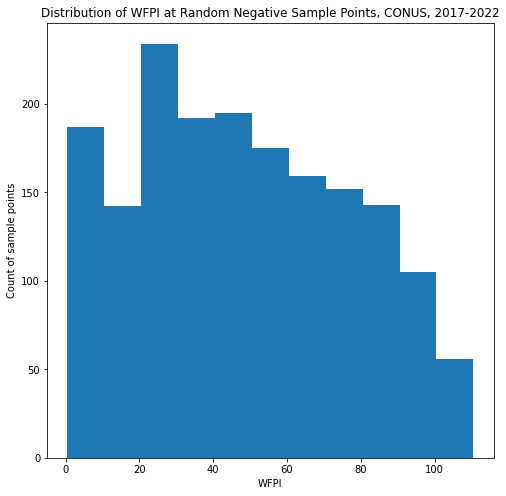

In [95]:
plt.figure(figsize=(8, 8))
plt.hist(negatve_sample_hazards, bins=[x+0.5 for x in range(0,120,10)])
plt.title("Distribution of WFPI at Random Negative Sample Points, CONUS, 2017-2022")
plt.xlabel('WFPI')
plt.ylabel('Count of sample points');

In [96]:
positive_sample_hazards = list(fire_hazards.values())
positive_sample_labels = [1]*len(positive_sample_hazards)
negative_sample_labels = [0]*len(positive_sample_hazards)
all_hazards = np.array(positive_sample_hazards + negatve_sample_hazards)
all_labels = np.array(positive_sample_labels + negative_sample_labels)
len(all_hazards), len(all_labels)

(5374, 5374)

In [100]:
valid_hazard_indices = np.where(all_hazards<=140)
len(valid_hazard_indices[0])/len(all_hazards)

0.7752139933010793

In [98]:
all_hazards_valid = all_hazards[valid_hazard_indices]/140
all_labels_valid = all_labels[valid_hazard_indices]

In [99]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

roc_auc_score(all_labels_valid, all_hazards_valid)

0.6831189819261063